In [1]:
import numpy as np 
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import umap
import os
import subprocess
import pickle
import subprocess
import scipy.sparse.linalg as lg
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import adjusted_rand_score as ARI
import partition_igraph
%config Completer.use_jedi = False

In [2]:
datadir = '../Datasets/'
abcd_path = 'ABCD/utils/'
n2v = '../node2vec/node2vec'
GED = '../GED/GED'

Functions taken from the Chapter 6 notebook:

In [3]:
## Computing JS divergence with GED code given edgelist, communities and embedding
def JS(edge_file, comm_file, embed_file, entropy=False):
    if entropy:
        x = GED+' -E -g '+edge_file+' -c '+comm_file+' -e '+embed_file
    else:
        x = GED+' -g '+edge_file+' -c '+comm_file+' -e '+embed_file
    s = subprocess.run(x, shell=True, stdout=subprocess.PIPE)
    x = s.stdout.decode().split(' ')
#     print(x)
    div = float(x[1])
    return(div)

## Laplacian eigenmaps embedding
def LE(g, dim=2):
    L_sym = np.array(g.laplacian(normalized=True))
    w, v = lg.eigs(L_sym, k=dim + 1, which='SM')
    idx = np.argsort(w) # sort eigenvalues
    w = w[idx]
    v = v[:, idx]
    X = v[:, 1:]
    return X.real

## save to disk to compute divergence
def saveEmbedding(X, g, fn='_embed'):
    with open(fn,'w') as f:
        f.write(str(X.shape[0]) + " " + str(X.shape[1])+'\n')
        for i in range(X.shape[0]):
            f.write(g.vs[i]['name']+' ')
            for j in range(X.shape[1]):
                f.write(str(X[i][j])+' ')
            f.write('\n')

In [4]:
# copied GitHub code to add ECG to the choice of community algorithms
def community_ecg(self, weights=None, ens_size=16, min_weight=0.05):
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain 
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l[p[x.tuple[0]]]==l[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    part = self.community_multilevel(weights=w)
    part.W = w
    part.CSI = 1-2*np.sum([min(1-i,i) for i in w])/len(w)
    return part
ig.Graph.community_ecg = community_ecg

### Problem 1

Generate the ABCD graph on $n=1\,000$ nodes with $\gamma=2.5$, $\beta=1.5$, and $\xi=0.2$. Pick 2 of your favourite embedding algorithms, with at least one of them being non-deterministic. For each algorithm and each dimension (4, 8, 16, 32, 64, 128):

In [5]:
## load the ABCD graph and generate ECG data file
ABCD = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_1000_xi2.dat',directed=False)
np.savetxt(datadir+'ABCD/abcd_1000_xi2.ecg', ABCD.community_ecg().membership,fmt='%s')

1. independently generate $k=30$ embeddings
2. evaluate the quality of each embedding by computing the divergence score (see the unsupervised benchmarking framework)

Generate embeddings and compute divergence scores using node2vec:

In [6]:
## first try a few different values of p and q for each dimesion to find the best choice

DIM = [4, 8,16,32, 64, 128]

best_pq = np.zeros([len(DIM), 4])
best_jsd = np.ones(len(DIM))

for d in range(len(DIM)):
    for (p,q) in [(1,0.1),(1,.5),(0.1,1),(.5,1),(1,1)]:
        x = n2v + ' -l:15 -i:'+datadir+'ABCD/abcd_1000_xi2.dat -o:_embed -d:'+str(DIM[d])+' -p:'+str(p)+' -q:'+str(q)
        r = os.system(x+' >/dev/null 2>&1')
        jsd = JS(datadir+'ABCD/abcd_1000_xi2.dat',datadir+'ABCD/abcd_1000_xi2.ecg','_embed')
        if jsd < best_jsd[d]:
            best_pq[d] = np.array([DIM[d], p, q, jsd])
            best_jsd[d] = jsd
            
D = pd.DataFrame(best_pq, columns=['Dim', 'Best p', 'Best q', 'Best JSD'])
D.head(6)

,Dim,Best p,Best q,Best JSD
0,4.0,1.0,0.5,0.001617
1,8.0,1.0,1.0,0.001582
2,16.0,0.1,1.0,0.001558
3,32.0,1.0,0.5,0.001557
4,64.0,0.1,1.0,0.001519


In [41]:
## independently generate 30 embeddings

reps = 30
n2v_jsd_scores = np.zeros([len(DIM),reps])

best_jsd = 1
worst_jsd = 0

for i in range(reps):
    for d in range(len(DIM)):
        x = n2v + ' -l:15 -i:'+datadir+'ABCD/abcd_1000_xi2.dat -o:_embed -d:'+str(DIM[d])+' -p:'+str(best_pq[d,1])+' -q:'+str(best_pq[d,2])
        r = os.system(x+' >/dev/null 2>&1')
        jsd = JS(datadir+'ABCD/abcd_1000_xi2.dat',datadir+'ABCD/abcd_1000_xi2.ecg','_embed') 
        n2v_jsd_scores[d, i] = jsd
        
        ## keep track of best and worst embeddings for Problem 2
        if jsd < best_jsd:
            os.system('cp _embed _embed_best')
            best_jsd = jsd
        if jsd > worst_jsd:
            os.system('cp _embed _embed_worst')
            worst_jsd = jsd

In [42]:
print(best_jsd, worst_jsd)

0.001464942 0.002202563


Compute embeddings using Laplacian eignemaps algorithm (just once) and compute divergence score

In [43]:
LE_jsd_scores = np.zeros(len(DIM))

for d in range(len(DIM)):
    X = LE(ABCD,dim=DIM[d])
    saveEmbedding(X,ABCD)
    jsd = JS(datadir+'ABCD/abcd_1000_xi2.dat',datadir+'ABCD/abcd_1000_xi2.ecg','_embed')
    LE_jsd_scores[d] = jsd
    
    ## keep track of best and worst embeddings for Problem 2
    if jsd < best_jsd:
        os.system('cp _embed _embed_best')
        best_jsd = jsd
    if jsd > worst_jsd:
        os.system('cp _embed _embed_worst')
        worst_jsd = jsd

In [44]:
print(best_jsd, worst_jsd)

0.00131717 0.002202563


3. compute the mean score (over 30 embeddings) and standard deviation

In [45]:
D = pd.DataFrame(np.column_stack([DIM, np.mean(n2v_jsd_scores, axis=1), np.std(n2v_jsd_scores, axis=1), LE_jsd_scores]), columns=['Embedding dimension', 'node2vec mean score', 'node2vec score std', 'Laplacian eigenmaps score'])
D.head(6)

,Embedding dimension,node2vec mean score,node2vec score std,Laplacian eigenmaps score
0,4.0,0.001806,0.000161,0.001536
1,8.0,0.001651,0.000095,0.001516
2,16.0,0.001575,0.000031,0.001505
3,32.0,0.001586,0.000022,0.001502
4,64.0,0.001525,0.000014,0.001471
5,128.0,0.001506,0.000015,0.001317


Which dimension produced the best embeddings (according to the framework) and which one is the most stable?

The highest dimension (128) produced the best embeddings using both node2vec and Laplacian eigenmaps, however, for the non-deterministic node2vec, a lower dimension of 64 was the most stable. 

### Problem 2

For the best and worst embedding (based on the unsupervised benchmarking framework evaluating all 360 embeddings that were generated in the previous problem), run the $k$-means algorithm using the known number of communities from the ABCD graph (ground truth). Compare the quality of the embeddings using AMI, ARI and AGRI.

Code from Chapter 6 notebook:

In [5]:
## 'N2K' mapping is used to map between node name and key value in graph when reading results from node2vec
def readEmbedding(fn="_embed", N2K=None):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    if N2K!=None:
        x = [N2K[i] for i in D[0]]
        D[0] = x    
        D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    return Y

In [46]:
## load graph and compute N2K mapping
ABCD = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_1000_xi2.dat',directed=False)
## map between int(name) to key
N2K = {int(v):k for k,v in enumerate(ABCD.vs['name'])}

In [61]:
## take the best and worst embeddings from Problem 1
X_best = readEmbedding(fn="_embed_best", N2K=None) # the best embedding is a LE embedding, so no need to use N2K mapping
X_worst = readEmbedding(fn="_embed_worst", N2K=N2K) # the worst embedding is a node2vec embedding

## obtain number of communities for k-means clustering
ground_truth = np.loadtxt(datadir+'ABCD/abcd_1000_xi2_comms.dat',dtype='uint16',usecols=(1))
k = max(ground_truth)
tc = {idx:part for idx,part in enumerate(ground_truth)}

REP = 10 ## number of repeats

## AMI, ARI, AGRI for the clustering done from the best and worst embeddings
ami_best = np.zeros(REP)
ami_worst = np.zeros(REP)
ari_best = np.zeros(REP)
ari_worst = np.zeros(REP)
agri_best = np.zeros(REP)
agri_worst = np.zeros(REP)

for i in range(REP):
    
    cl_best = KMeans(n_clusters=k).fit(X_best)
    cc = {idx:part+1 for idx,part in enumerate(cl_best.labels_)} 
    ami_best[i] = AMI(ground_truth,cl_best.labels_+1)
    ari_best[i] = ARI(ground_truth,cl_best.labels_+1)
    agri_best[i] = ABCD.gam(tc, cc)
    
    cl_worst = KMeans(n_clusters=k).fit(X_worst)
    cc = {idx:part+1 for idx,part in enumerate(cl_worst.labels_)} 
    ami_best[i] = AMI(ground_truth,cl_worst.labels_+1)
    ari_best[i] = ARI(ground_truth,cl_worst.labels_+1)
    agri_best[i] = ABCD.gam(tc, cc)
    
D = pd.DataFrame({"AMI":[np.mean(ami_best), np.mean(ami_worst)], "ARI":[np.mean(ari_best), np.mean(ari_worst)], "AGRI":[np.mean(agri_best), np.mean(agri_worst)]})
D.index =['Best embedding', 'Worst embedding']
D.head()

,AMI,ARI,AGRI
Best embedding,0.00353,0.000251,0.010429
Worst embedding,0.00000,0.000000,0.000000


Even the best embedding produces scores which are quite low. The scores from the ECG partition against the ground truth are also low, there's probably an error in my code somewhere. 

In [62]:
ecg = ABCD.community_ecg().membership
ecg = [i+1 for i in ecg]
ecg_dict = {idx:part+1 for idx,part in enumerate(ecg)} 
print('AMI: ', AMI(ground_truth, ecg), ' ARI: ', ARI(ground_truth, ecg), ' AGRI: ',ABCD.gam(tc, ecg_dict))

AMI:  -0.0029661362266077606  ARI:  -0.0005999265334938094  AGRI:  0.0034231098355238425


### Problem 3

Take a ring of cliques. For each algorithm you picked in the previous problem, and each dimension (4, 8, 16, 32, 64, 128):

1. independently generate $k=30$ embeddings
2. evaluate the quality of each embedding by computing the divergence score (see the unsupervised benchmarking framework)

Using code from the Chapter 5 notebook for generating a ring of cliques:

In [46]:
## n cliques of size s
def ringOfCliques(n,s):
    roc = ig.Graph.Erdos_Renyi(n=n*s,p=0)
    ## cliques
    for i in range(n):
        for j in np.arange(s*i,s*(i+1)):
            for k in np.arange(j+1,s*(i+1)):
                roc.add_edge(j,k)
    ## ring
    for i in range(n):
        if i>0:
            roc.add_edge(s*i-1,s*i)
        else:
            roc.add_edge(n*s-1,0)

    return roc

## 10 20-cliques
roc = ringOfCliques(10,20)     

In [47]:
## save graph data and ecg files
edges = np.array([edge.tuple for edge in roc.es])
np.savetxt('roc.dat', edges.astype(int), fmt='%i')
np.savetxt('roc.ecg', roc.community_ecg().membership,fmt='%s')

Generate embeddings and compute divergence scores using node2vec:

In [48]:
## first try a few different values of p and q for each dimesion to find the best choice

DIM = [4, 8,16,32, 64, 128]

best_pq = np.zeros([len(DIM), 4])
best_jsd = np.ones(len(DIM))

for d in range(len(DIM)):
    for (p,q) in [(1,0.1),(1,.5),(0.1,1),(.5,1),(1,1)]:
        x = n2v + ' -l:15 -i:'+'roc.dat -o:_embed -d:'+str(DIM[d])+' -p:'+str(p)+' -q:'+str(q)
        r = os.system(x+' >/dev/null 2>&1')
        jsd = JS('roc.dat','roc.ecg','_embed')
        if jsd < best_jsd[d]:
            best_pq[d] = np.array([DIM[d], p, q, jsd])
            best_jsd[d] = jsd
            
D = pd.DataFrame(best_pq, columns=['Dim', 'Best p', 'Best q', 'Best JSD'])
D.head(6)

,Dim,Best p,Best q,Best JSD
0,4.0,0.5,1.0,0.003228
1,8.0,0.1,1.0,0.000249
2,16.0,0.1,1.0,0.000195
3,32.0,1.0,1.0,0.000167
4,64.0,1.0,1.0,0.000108


In [49]:
## independently generate 30 embeddings

reps = 30
n2v_jsd_scores = np.zeros([len(DIM),reps])

best_jsd = 1
worst_jsd = 0

for i in range(reps):
    for d in range(len(DIM)):
        x = n2v + ' -l:15 -i:'+'roc.dat -o:_embed -d:'+str(DIM[d])+' -p:'+str(best_pq[d,1])+' -q:'+str(best_pq[d,2])
        r = os.system(x+' >/dev/null 2>&1')
        jsd = JS('roc.dat','roc.ecg','_embed') 
        n2v_jsd_scores[d, i] = jsd
        
        ## keep track of best and worst embeddings for Problem 2
        if jsd < best_jsd:
            os.system('cp _embed _embed_best_roc')
            best_jsd = jsd
        if jsd > worst_jsd:
            os.system('cp _embed _embed_worst_roc')
            worst_jsd = jsd
            
print(best_jsd, worst_jsd)

5.515918e-05 0.02555293


Compute embeddings using Laplacian eignemaps algorithm and compute divergence score:

In [50]:
LE_jsd_scores = np.zeros(len(DIM))
roc = ig.Graph.Read_Ncol('roc.dat',directed=False) # this ensures the 'name' attribute of vertices is set

for d in range(len(DIM)):
    X = LE(roc,dim=DIM[d])
    saveEmbedding(X,roc)
    jsd = JS('roc.dat','roc.ecg','_embed')
    LE_jsd_scores[d] = jsd
    
    ## keep track of best and worst embeddings for Problem 2
    if jsd < best_jsd:
        os.system('cp _embed _embed_best_roc')
        best_jsd = jsd
    if jsd > worst_jsd:
        os.system('cp _embed _embed_worst_roc')
        worst_jsd = jsd
        
print(best_jsd, worst_jsd)

5.515918e-05 0.4514836


3. Select the best embedding and the worst embedding (according to the framework) from all embeddings you created, reduce the dimension to 2 using UMAP, and plot both of them highlighting the cliques with colors. 

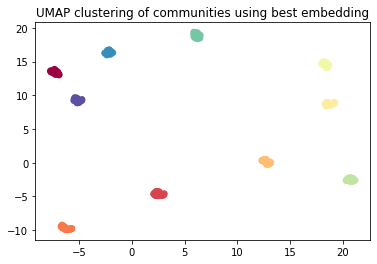

In [56]:
## map between int(name) to key
N2K = {int(v):k for k,v in enumerate(roc.vs['name'])}

X_best = readEmbedding(fn="_embed_best_roc", N2K=N2K) # the best embedding is a node2vec embedding

U = umap.UMAP(n_components=2).fit_transform(X_best)
c = np.repeat(np.arange(10), 20) # ground truth communities for coloring
plt.scatter(U[:, 0], U[:, 1], c=c, cmap='Spectral')
plt.title("UMAP clustering of communities using best embedding")
plt.show()

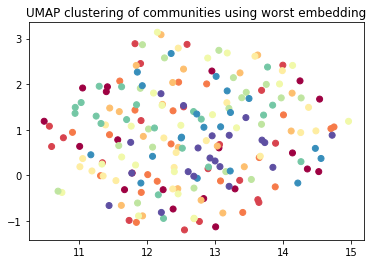

In [57]:
X_worst = readEmbedding(fn="_embed_worst_roc", N2K=None) # the worst embedding is a LE embedding

U = umap.UMAP(n_components=2).fit_transform(X_worst)
plt.scatter(U[:, 0], U[:, 1], c=c, cmap='Spectral')
plt.title("UMAP clustering of communities using worst embedding")
plt.show()

### Problem 4

Repeat the above experiment (plotting the best and worst embedding) for the giant component of the subset of the European Grid network. 

In [19]:
## read edge list for the grid network and build undirected graph
gr = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
gr = gr.simplify()

## read the vertices along with some of the attributes
X = pd.read_csv(datadir+'GridEurope/gridkit_europe-highvoltage.vertices')
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()] ## tuples with lat/lon

## get giant component
sg = gr.clusters().giant()

## save graph data and ecg files
edges = np.array([edge.tuple for edge in sg.es])
np.savetxt('eurogrid.dat', edges.astype(int), fmt='%i')
np.savetxt('eurogrid.ecg', sg.community_ecg().membership,fmt='%s')
np.savetxt('eurogrid.latlon', np.column_stack([np.array(sg.vs['latitude']),np.array(sg.vs['longitude'])]))

node2vec:

In [60]:
## first try a few different values of p and q for each dimesion to find the best choice

DIM = [4, 8,16,32, 64, 128]

best_pq = np.zeros([len(DIM), 4])
best_jsd = np.ones(len(DIM))

for d in range(len(DIM)):
    for (p,q) in [(1,0.1),(1,.5),(0.1,1),(.5,1),(1,1)]:
        x = n2v + ' -l:15 -i:'+'eurogrid.dat -o:_embed -d:'+str(DIM[d])+' -p:'+str(p)+' -q:'+str(q)
        r = os.system(x+' >/dev/null 2>&1')
        jsd = JS('eurogrid.dat','eurogrid.ecg','_embed')
        if jsd < best_jsd[d]:
            best_pq[d] = np.array([DIM[d], p, q, jsd])
            best_jsd[d] = jsd
            
D = pd.DataFrame(best_pq, columns=['Dim', 'Best p', 'Best q', 'Best JSD'])
D.head(6)

,Dim,Best p,Best q,Best JSD
0,4.0,1.0,0.5,0.162707
1,8.0,1.0,0.1,0.123429
2,16.0,1.0,0.1,0.063414
3,32.0,1.0,0.1,0.031257
4,64.0,1.0,0.5,0.018207
5,128.0,1.0,0.5,0.012824


In [61]:
## independently generate 30 embeddings

reps = 30
n2v_jsd_scores = np.zeros([len(DIM),reps])

best_jsd = 1
worst_jsd = 0

for i in range(reps):
    for d in range(len(DIM)):
        x = n2v + ' -l:15 -i:'+'eurogrid.dat -o:_embed -d:'+str(DIM[d])+' -p:'+str(best_pq[d,1])+' -q:'+str(best_pq[d,2])
        r = os.system(x+' >/dev/null 2>&1')
        jsd = JS('eurogrid.dat','eurogrid.ecg','_embed') 
        n2v_jsd_scores[d, i] = jsd
        
        ## keep track of best and worst embeddings for Problem 2
        if jsd < best_jsd:
            os.system('cp _embed _embed_best_eurogrid')
            best_jsd = jsd
        if jsd > worst_jsd:
            os.system('cp _embed _embed_worst_eurogrid')
            worst_jsd = jsd
            
print(best_jsd, worst_jsd)

0.01220314 0.1654704


Laplacian eigenmaps:

In [67]:
LE_jsd_scores = np.zeros(len(DIM))

sg = ig.Graph.Read_Ncol('eurogrid.dat',directed=False) # this ensures the 'name' attribute of vertices is set

for d in range(len(DIM)):
    X = LE(sg,dim=DIM[d])
    saveEmbedding(X,sg)
    jsd = JS('eurogrid.dat','eurogrid.ecg','_embed')
    LE_jsd_scores[d] = jsd
    
    ## keep track of best and worst embeddings for Problem 2
    if jsd < best_jsd:
        os.system('cp _embed _embed_best_eurogrid')
        best_jsd = jsd
    if jsd > worst_jsd:
        os.system('cp _embed _embed_worst_eurogrid')
        worst_jsd = jsd
        
print(best_jsd, worst_jsd)

0.01220314 0.1654704


Additionally, 
1. find the communities of that graph using ECG and color nodes accordingly

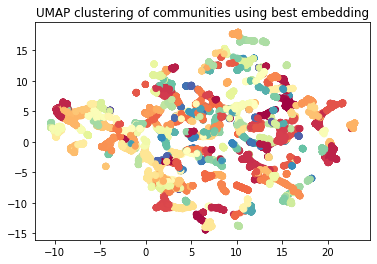

In [6]:
## map between int(name) to key

sg = ig.Graph.Read_Ncol('eurogrid.dat',directed=False) # this ensures the 'name' attribute of vertices is set

N2K = {int(v):k for k,v in enumerate(sg.vs['name'])}

X_best = readEmbedding(fn="_embed_best_eurogrid", N2K=N2K) # the best embedding is a node2vec embedding

U = umap.UMAP(n_components=2).fit_transform(X_best)
c = sg.community_ecg().membership # communities according to ecg
plt.scatter(U[:, 0], U[:, 1], c=c, cmap='Spectral')
plt.title("UMAP clustering of communities using best embedding")
plt.show()

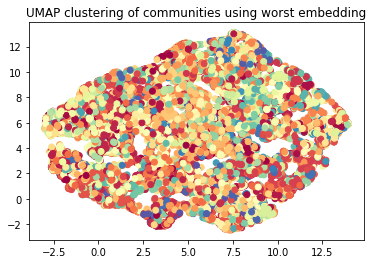

In [7]:
X_worst = readEmbedding(fn="_embed_worst_eurogrid", N2K=N2K) # the worst embedding is a node2vec embedding

U = umap.UMAP(n_components=2).fit_transform(X_worst)
plt.scatter(U[:, 0], U[:, 1], c=c, cmap='Spectral')
plt.title("UMAP clustering of communities using worst embedding")
plt.show()

2. for each pair of nodes, compute the distance in the embedded space and the geographical distance and create a scatter plot

In [ ]:
from geopy import distance

sg = ig.Graph.Read_Ncol('eurogrid.dat',directed=False) # this ensures the 'name' attribute of vertices is set

## map between int(name) to key
N2K = {int(v):k for k,v in enumerate(sg.vs['name'])}

X_best = readEmbedding(fn="_embed_best_eurogrid", N2K=N2K) # the best embedding is a node2vec embedding
X_worst = readEmbedding(fn="_embed_worst_eurogrid", N2K=N2K) # the worst embedding is a node2vec embedding


lat_long = np.loadtxt('eurogrid.latlon')

geo_distance = []
embed_distance_best = []
embed_distance_worst = []


for u in range(sg.vcount()):
    frac = u*100//sg.vcount()
    if frac%10 == 0:
        print(frac)
    for v in range(u):
        geo_distance.append(distance.distance((lat_long[u, 0], lat_long[u, 1]), (lat_long[v, 0], lat_long[v, 1])).km)
        embed_distance_best.append(np.linalg.norm(X_best[u] - X_best[v]))
        embed_distance_worst.append(np.linalg.norm(X_worst[u] - X_worst[v]))

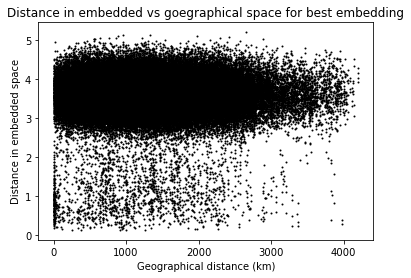

In [16]:
plt.scatter(geo_distance[:100000], embed_distance_best[:100000], c='k', s=1) # ran into memory problems using entire lists
plt.xlabel('Geographical distance (km)')
plt.ylabel('Distance in embedded space')
plt.title('Distance in embedded vs goegraphical space for best embedding')
plt.show()

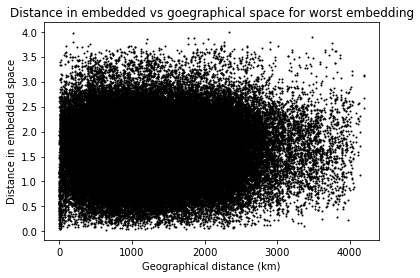

In [17]:
plt.scatter(geo_distance[:100000], embed_distance_worst[:100000], c='k', s=1)
plt.xlabel('Geographical distance (km)')
plt.ylabel('Distance in embedded space')
plt.title('Distance in embedded vs goegraphical space for worst embedding')
plt.show()

3. partition all pairs of nodes into 10 buckets of equal size based on their distance (i.e. the first bucket consists of pairs of nodes that are cose to each other and the last one pairs of nodes that are far from each other); compute the number of edges that fall into each bucket. What can you conclude?

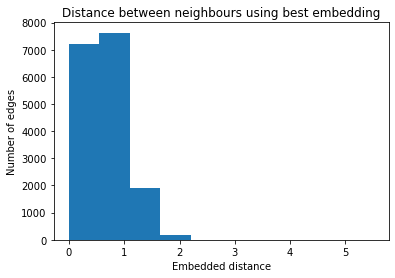

In [13]:
bin_edges = np.linspace(0, max(embed_distance_best), 11)

edge_distances = []

edges = np.array([edge.tuple for edge in sg.es])
for i in range(len(edges)):
    edge_distances.append(np.linalg.norm(X_best[edges[i, 0]]-X_best[edges[i, 1]]))
    
plt.hist(edge_distances, bins=bin_edges)
plt.xlabel('Embedded distance')
plt.ylabel('Number of edges')
plt.title('Distance between neighbours using best embedding')
plt.show()

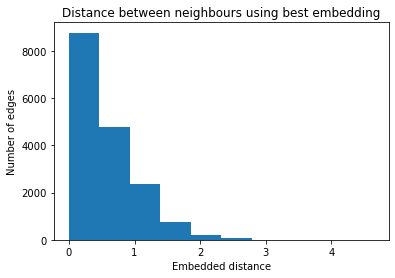

In [18]:
bin_edges = np.linspace(0, max(embed_distance_worst), 11)

edge_distances = []

edges = np.array([edge.tuple for edge in sg.es])
for i in range(len(edges)):
    edge_distances.append(np.linalg.norm(X_worst[edges[i, 0]]-X_worst[edges[i, 1]]))
    
plt.hist(edge_distances, bins=bin_edges)
plt.xlabel('Embedded distance')
plt.ylabel('Number of edges')
plt.title('Distance between neighbours using best embedding')
plt.show()

The best embedding does a better job at minimizing the number of long edges in embedding space. 